In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms import InterpolationMode
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm



In [2]:
def plot_class_distribution(dataset, title):
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1

    plt.figure(figsize=(6, 4))
    sns.barplot(x=dataset.classes, y=class_counts)
    plt.title(f'Class Distribution - {title}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def show_original_vs_augmented(dataset):
    original_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BILINEAR),  # Fix applied
    transforms.ToTensor()
    ])

    augmented_transform = transform

    image_path, label = dataset.samples[0]
    original_image = original_transform(datasets.folder.default_loader(image_path))
    augmented_image = augmented_transform(datasets.folder.default_loader(image_path))

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    original_image_disp = original_image * 0.5 + 0.5
    axs[0].imshow(np.transpose(original_image_disp.numpy(), (1, 2, 0)))
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    augmented_image_disp = augmented_image * 0.5 + 0.5
    axs[1].imshow(np.transpose(augmented_image_disp.numpy(), (1, 2, 0)))
    axs[1].set_title("Augmented Image")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()



In [3]:
# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.2):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x), need_weights=True)[0]
        x = x + self.mlp(self.norm2(x))
        return x

# Masked Autoencoder (MAE)
class MaskedAutoencoder(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, num_layers, mask_ratio=0.75):
        super().__init__()
        self.feature_extractor = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT).features
        self.fc = nn.Linear(1280, embed_dim)

        self.mask_ratio = mask_ratio
        self.transformer = nn.Sequential(*[TransformerBlock(embed_dim, num_heads, hidden_dim, DROPOUT) for _ in range(num_layers)])
        self.decoder = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        features = self.feature_extractor(x)
        features = F.adaptive_avg_pool2d(features, (1, 1)).view(features.size(0), -1)
        features = self.fc(features)

        mask = torch.rand(features.shape, device=device) > self.mask_ratio
        masked_features = features * mask

        encoded = self.transformer(masked_features.unsqueeze(1))
        reconstructed = self.decoder(encoded.squeeze(1))
        return reconstructed, features
# Pretraining MAE
def pretrain_mae(mae, train_loader, epochs=10):
    optimizer = torch.optim.AdamW(mae.parameters(), lr=3e-4, weight_decay=1e-4)
    criterion = nn.MSELoss()
    mae.train()

    for epoch in range(epochs):
        total_loss = 0.0
        loop = tqdm(train_loader, desc=f"Pretrain Epoch {epoch+1}/{epochs}")
        for images, _ in loop:
            images = images.to(device)
            optimizer.zero_grad()
            reconstructed, original = mae(images)
            loss = criterion(reconstructed, original)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Classification Model
class EnhancedViT(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, hidden_dim, num_classes):
        super().__init__()
        self.mae = MaskedAutoencoder(embed_dim, num_heads, hidden_dim, num_layers)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        _, features = self.mae(x)
        return self.fc(features)


In [4]:
# Classifier Training with Loss Plot
def train_classifier(classifier, train_loader, val_loader, epochs=10):
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=3e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        classifier.train()
        total_train_loss = 0.0
        loop = tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{epochs}")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        train_loss_avg = total_train_loss / len(train_loader)
        train_losses.append(train_loss_avg)

        classifier.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = classifier(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        val_loss_avg = total_val_loss / len(val_loader)
        val_losses.append(val_loss_avg)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}")
        torch.save(classifier.state_dict(), MODEL_PATH)

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
# Evaluation
def evaluate_classifier(classifier, test_loader):
    classifier.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


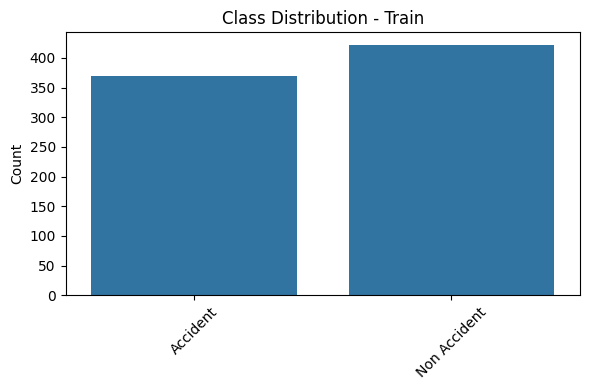

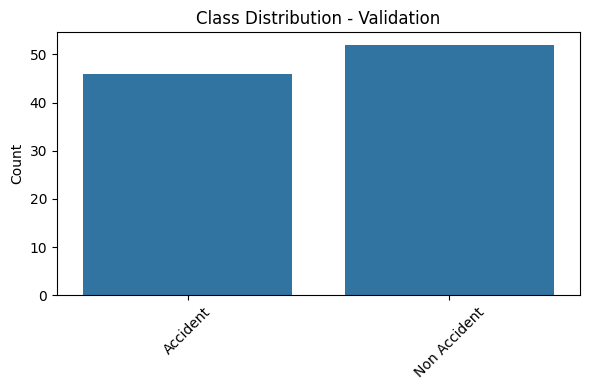

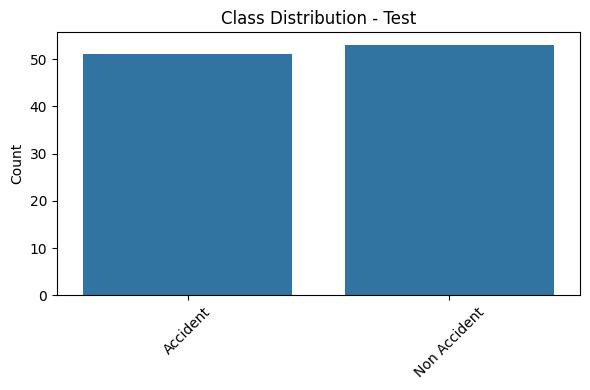

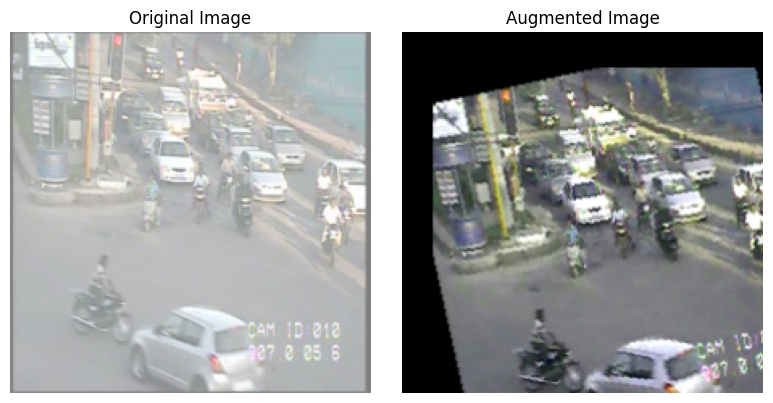

Pretrain Epoch 1/10: 100%|█████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.19it/s, loss=0.292]


Epoch 1/10, Loss: 0.5490


Pretrain Epoch 2/10: 100%|█████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.22it/s, loss=0.138]


Epoch 2/10, Loss: 0.1945


Pretrain Epoch 3/10: 100%|████████████████████████████████████████████████| 25/25 [00:18<00:00,  1.34it/s, loss=0.0827]


Epoch 3/10, Loss: 0.1068


Pretrain Epoch 4/10: 100%|████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.54it/s, loss=0.0615]


Epoch 4/10, Loss: 0.0728


Pretrain Epoch 5/10: 100%|████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s, loss=0.0462]


Epoch 5/10, Loss: 0.0547


Pretrain Epoch 6/10: 100%|████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.25it/s, loss=0.0395]


Epoch 6/10, Loss: 0.0437


Pretrain Epoch 7/10: 100%|████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.26it/s, loss=0.0317]


Epoch 7/10, Loss: 0.0360


Pretrain Epoch 8/10: 100%|█████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.15it/s, loss=0.027]


Epoch 8/10, Loss: 0.0306


Pretrain Epoch 9/10: 100%|█████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.27it/s, loss=0.025]


Epoch 9/10, Loss: 0.0260


Pretrain Epoch 10/10: 100%|███████████████████████████████████████████████| 25/25 [00:15<00:00,  1.58it/s, loss=0.0211]


Epoch 10/10, Loss: 0.0226


C:\Users\madhu\AppData\Local\Temp\ipykernel_17832\1820299599.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.mae.load_state_dict(torch.load(MODEL_PATH))
Trai

Epoch 1/15, Train Loss: 0.6147, Val Loss: 0.3575


Train Epoch 2/15: 100%|████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.76it/s, loss=0.459]


Epoch 2/15, Train Loss: 0.4160, Val Loss: 0.3311


Train Epoch 3/15: 100%|████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.63it/s, loss=0.213]


Epoch 3/15, Train Loss: 0.2722, Val Loss: 0.1455


Train Epoch 4/15: 100%|████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.06it/s, loss=0.185]


Epoch 4/15, Train Loss: 0.2653, Val Loss: 0.1990


Train Epoch 5/15: 100%|████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.59it/s, loss=0.168]


Epoch 5/15, Train Loss: 0.2134, Val Loss: 0.2499


Train Epoch 6/15: 100%|████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.87it/s, loss=0.116]


Epoch 6/15, Train Loss: 0.1711, Val Loss: 0.1602


Train Epoch 7/15: 100%|████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.59it/s, loss=0.209]


Epoch 7/15, Train Loss: 0.1498, Val Loss: 0.2463


Train Epoch 8/15: 100%|████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.62it/s, loss=0.126]


Epoch 8/15, Train Loss: 0.1414, Val Loss: 0.2641


Train Epoch 9/15: 100%|████████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.41it/s, loss=0.215]


Epoch 9/15, Train Loss: 0.1333, Val Loss: 0.3028


Train Epoch 10/15: 100%|██████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.25it/s, loss=0.0695]


Epoch 10/15, Train Loss: 0.1645, Val Loss: 0.2510


Train Epoch 11/15: 100%|███████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.33it/s, loss=0.111]


Epoch 11/15, Train Loss: 0.1199, Val Loss: 0.2335


Train Epoch 12/15: 100%|███████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.29it/s, loss=0.556]


Epoch 12/15, Train Loss: 0.1310, Val Loss: 0.3475


Train Epoch 13/15: 100%|██████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.56it/s, loss=0.0669]


Epoch 13/15, Train Loss: 0.1373, Val Loss: 0.2164


Train Epoch 14/15: 100%|███████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.79it/s, loss=0.135]


Epoch 14/15, Train Loss: 0.0984, Val Loss: 0.1512


Train Epoch 15/15: 100%|██████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.76it/s, loss=0.0431]


Epoch 15/15, Train Loss: 0.1363, Val Loss: 0.2050


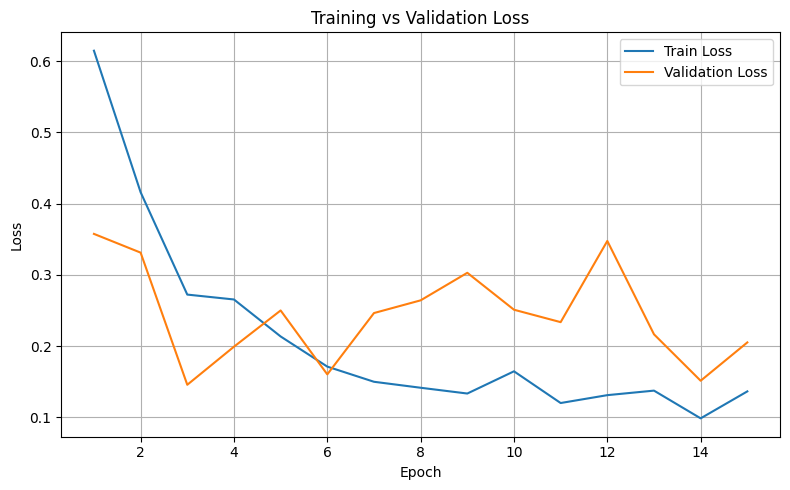

Test Accuracy: 0.9712, Precision: 0.9727, Recall: 0.9712, F1 Score: 0.9711


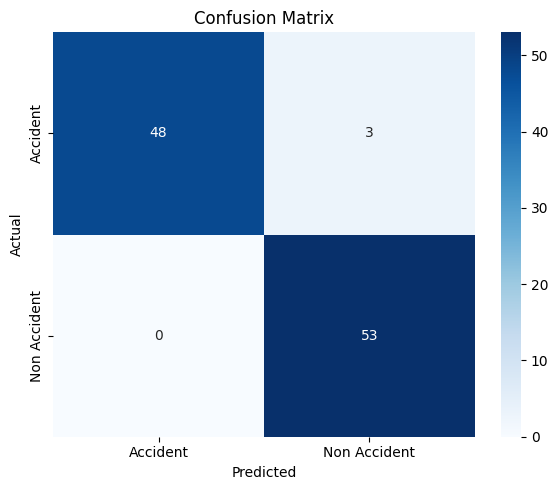

In [8]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
IMG_SIZE = 224
EMBED_DIM = 256
NUM_HEADS = 8
NUM_LAYERS = 12
HIDDEN_DIM = 512
DROPOUT = 0.2
NUM_CLASSES = 2
MASK_RATIO = 0.75
MODEL_PATH = "enhanced_vit_efficientnet_final8.pth"

# Data transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(degrees=15),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),   
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Datasets
train_dataset = datasets.ImageFolder("data/data/train", transform=transform)
val_dataset = datasets.ImageFolder("data/data/val", transform=transform)
test_dataset = datasets.ImageFolder("data/data/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

plot_class_distribution(train_dataset, "Train")
plot_class_distribution(val_dataset, "Validation")
plot_class_distribution(test_dataset, "Test")
show_original_vs_augmented(train_dataset)

# --- Execution ---
mae = MaskedAutoencoder(EMBED_DIM, NUM_HEADS, HIDDEN_DIM, NUM_LAYERS).to(device)
pretrain_mae(mae, train_loader, epochs=10)
torch.save(mae.state_dict(), MODEL_PATH)

classifier = EnhancedViT(EMBED_DIM, NUM_HEADS, NUM_LAYERS, HIDDEN_DIM, NUM_CLASSES).to(device)
classifier.mae.load_state_dict(torch.load(MODEL_PATH))
train_classifier(classifier, train_loader, val_loader, epochs=15)
evaluate_classifier(classifier, test_loader)

In [5]:
# Transformer Block
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms import InterpolationMode
from PIL import Image
from models import EnhancedViT  # Import your model

IMG_SIZE = 224
EMBED_DIM = 256
NUM_HEADS = 8
NUM_LAYERS = 12
HIDDEN_DIM = 512
DROPOUT = 0.2
NUM_CLASSES = 2
MASK_RATIO = 0.75
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = EnhancedViT(EMBED_DIM, NUM_HEADS, NUM_LAYERS,HIDDEN_DIM , NUM_CLASSES).to(device)
model.load_state_dict(torch.load("enhanced_vit_efficientnet_final8.pth"))  # Ensure you have a trained model saved
model.eval()

# Define image transformations (same as used in training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match EfficientNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load a test image
img = Image.open("data/data/test/Non Accident/test16_4.jpg")  # Replace with your test image
img = transform(img).unsqueeze(0).to(device)  # Add batch dimension

# Run the model
with torch.no_grad():
    output = model(img)
    predicted_class = torch.argmax(output, dim=1).item()

if predicted_class == 0:
    print(f"Predicted Class: Accident")
else:
    print(f"Predicted Class: Non-Accident")



C:\Users\madhu\AppData\Local\Temp\ipykernel_17308\141478003.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("enhanced_vit_efficientnet_

Predicted Class: Non-Accident
